In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

Mounted at /content/drive


In [2]:
!pip install lime==0.2.0.1
!pip install shap==0.35.0
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=9f369da969a52adb0d459cda15baef0111dfae0160b672060d5a54cbca1d09c1
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394128 sha256=d1bfaec29c4e3570b7938d90e09505b6614e78d51f7571f3647fcb51e77beafb
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
     |████████████████████████████████| 109.8MB 47kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "sepsis_cases"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 25

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"]#, "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['sepsis_cases_1']

Bucket 21
Generating distributions for bucket
1 of 505 features
2 of 505 features
3 of 505 features
4 of 505 features
5 of 505 features
6 of 505 features
7 of 505 features
8 of 505 features
9 of 505 features
10 of 505 features
11 of 505 features
12 of 505 features
13 of 505 features
14 of 505 features
15 of 505 features
16 of 505 features
17 of 505 features
18 of 505 features
19 of 505 features
20 of 505 features
21 of 505 features
22 of 505 features
23 of 505 features
24 of 505 features
25 of 505 features
26 of 505 features
27 of 505 features
28 of 505 features
29 of 505 features
30 of 505 features
31 of 505 features
32 of 505 features
33 of 505 features
34 of 505 features
35 of 505 features
36 of 505 features
37 of 505 features
38 of 505 features
39 of 505 features
40 of 505 features
41 of 505 features
42 of 505 features
43 of 505 features
44 of 505 features
45 of 505 features
46 of 505 features
47 of 505 features
48 of 505 features
49 of 505 features
50 of 505 features
51 of 505 fea

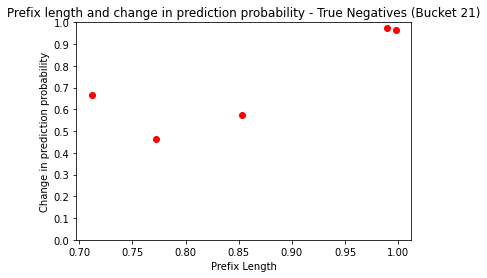

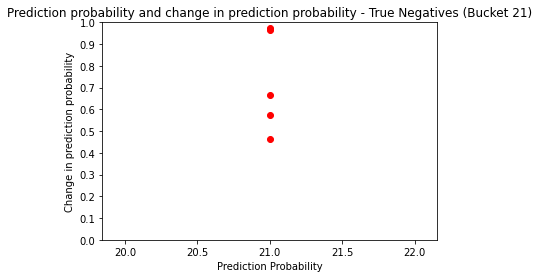

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 50
Creating distribution for feature 2 of 50
Creating distribution for feature 3 of 50
Creating distribution for feature 4 of 50
Creating distribution for feature 5 of 50
Creating distribution for feature 6 of 50
Creating distribution for feature 7 of 50
Creating distribution for feature 8 of 50
Creating distribution for feature 9 of 50
Creating distribution for feature 10 of 50
Creating distribution for feature 11 of 50
Creating distribution for feature 12 of 50
Creating distribution for feature 13 of 50
Creating distribution for feature 14 of 50
Creating distribution for feature 15 of 50
Creating distribution for feature 16 of 50
Creating distribution for feature 17 of 50
Creating distribution for feature 18 of 50
Creating distribution for feature 19 of 50
Creating distribution for feature 20 of 50
Creating distribution for feature 21 of 50
Creating distribution

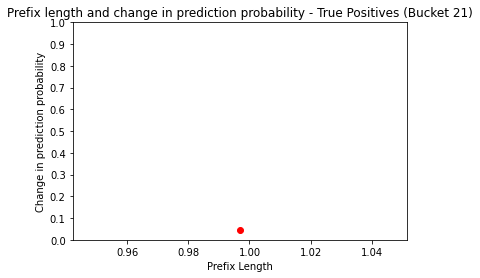

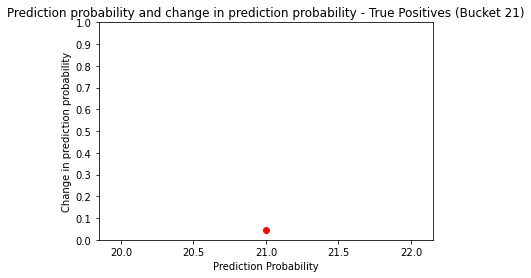

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 50
Creating distribution for feature 2 of 50
Creating distribution for feature 3 of 50
Creating distribution for feature 4 of 50
Creating distribution for feature 5 of 50
Creating distribution for feature 6 of 50
Creating distribution for feature 7 of 50
Creating distribution for feature 8 of 50
Creating distribution for feature 9 of 50
Creating distribution for feature 10 of 50
Creating distribution for feature 11 of 50
Creating distribution for feature 12 of 50
Creating distribution for feature 13 of 50
Creating distribution for feature 14 of 50
Creating distribution for feature 15 of 50
Creating distribution for feature 16 of 50
Creating distribution for feature 17 of 50
Creating distribution for feature 18 of 50
Creating distribution for feature 19 of 50
Creating distribution for feature 20 of 50
Creating distribution for feature 21 of 50
Creating distribution

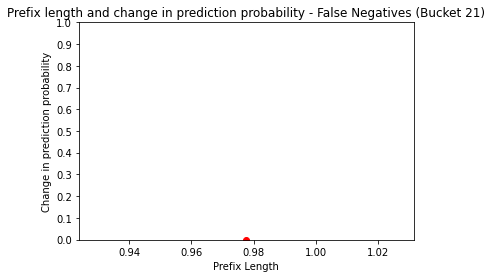

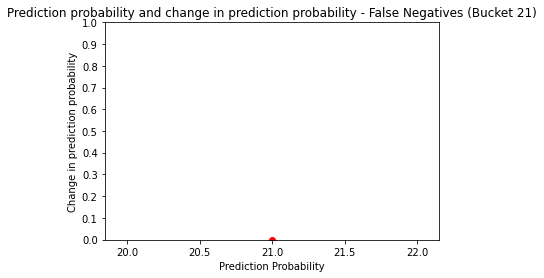

Category 4 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 50
Creating distribution for feature 2 of 50
Creating distribution for feature 3 of 50
Creating distribution for feature 4 of 50
Creating distribution for feature 5 of 50
Creating distribution for feature 6 of 50
Creating distribution for feature 7 of 50
Creating distribution for feature 8 of 50
Creating distribution for feature 9 of 50
Creating distribution for feature 10 of 50
Creating distribution for feature 11 of 50
Creating distribution for feature 12 of 50
Creating distribution for feature 13 of 50
Creating distribution for feature 14 of 50
Creating distribution for feature 15 of 50
Creating distribution for feature 16 of 50
Creating distribution for feature 17 of 50
Creating distribution for feature 18 of 50
Creating distribution for feature 19 of 50
Creating distribution for feature 20 of 50
Creating distribution for feature 21 of 50
Creating distribution

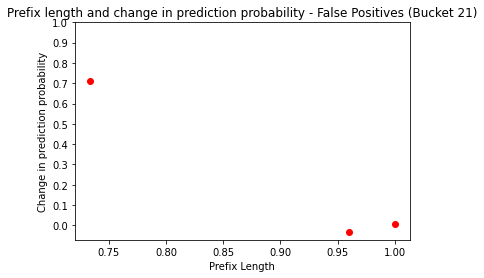

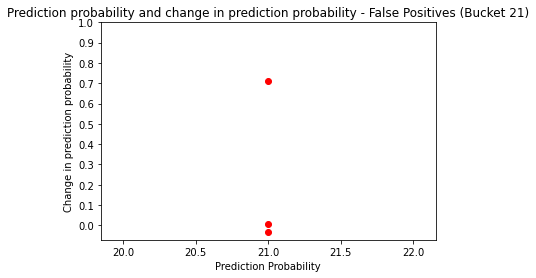

Bucket 22
Generating distributions for bucket
1 of 484 features
2 of 484 features
3 of 484 features
4 of 484 features
5 of 484 features
6 of 484 features
7 of 484 features
8 of 484 features
9 of 484 features
10 of 484 features
11 of 484 features
12 of 484 features
13 of 484 features
14 of 484 features
15 of 484 features
16 of 484 features
17 of 484 features
18 of 484 features
19 of 484 features
20 of 484 features
21 of 484 features
22 of 484 features
23 of 484 features
24 of 484 features
25 of 484 features
26 of 484 features
27 of 484 features
28 of 484 features
29 of 484 features
30 of 484 features
31 of 484 features
32 of 484 features
33 of 484 features
34 of 484 features
35 of 484 features
36 of 484 features
37 of 484 features
38 of 484 features
39 of 484 features
40 of 484 features
41 of 484 features
42 of 484 features
43 of 484 features
44 of 484 features
45 of 484 features
46 of 484 features
47 of 484 features
48 of 484 features
49 of 484 features
50 of 484 features
51 of 484 fea

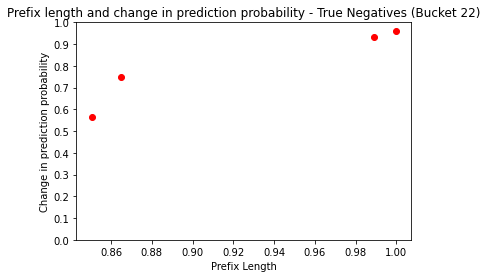

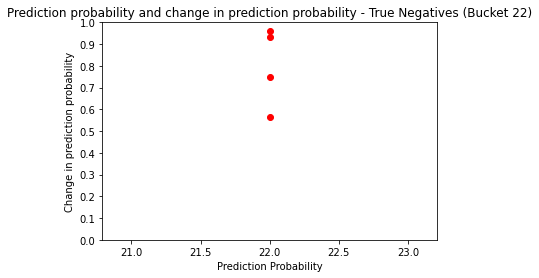

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

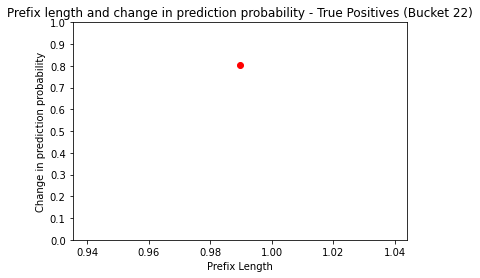

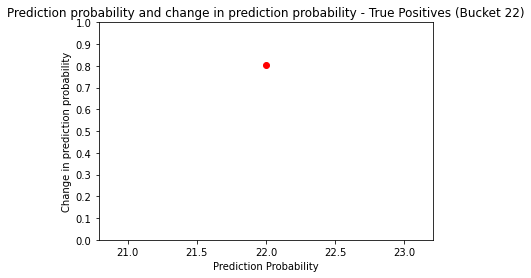

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

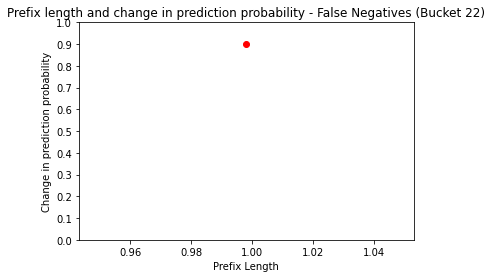

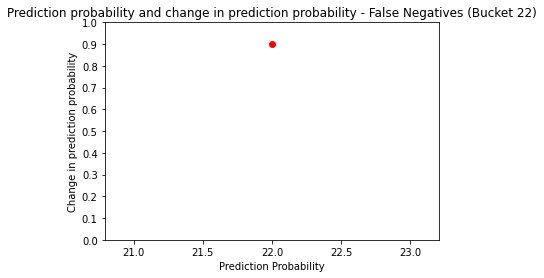

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

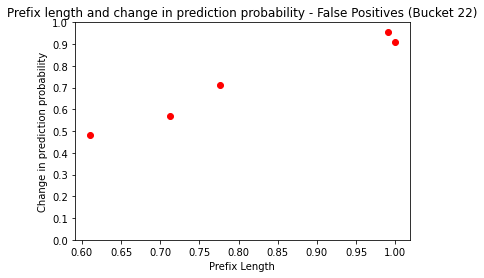

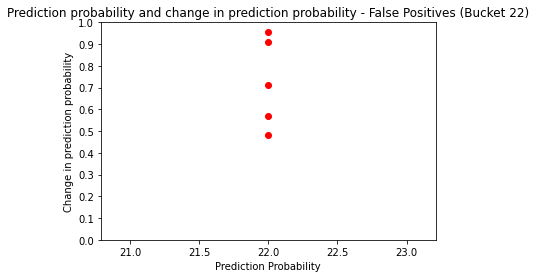

Bucket 23
Generating distributions for bucket
1 of 503 features
2 of 503 features
3 of 503 features
4 of 503 features
5 of 503 features
6 of 503 features
7 of 503 features
8 of 503 features
9 of 503 features
10 of 503 features
11 of 503 features
12 of 503 features
13 of 503 features
14 of 503 features
15 of 503 features
16 of 503 features
17 of 503 features
18 of 503 features
19 of 503 features
20 of 503 features
21 of 503 features
22 of 503 features
23 of 503 features
24 of 503 features
25 of 503 features
26 of 503 features
27 of 503 features
28 of 503 features
29 of 503 features
30 of 503 features
31 of 503 features
32 of 503 features
33 of 503 features
34 of 503 features
35 of 503 features
36 of 503 features
37 of 503 features
38 of 503 features
39 of 503 features
40 of 503 features
41 of 503 features
42 of 503 features
43 of 503 features
44 of 503 features
45 of 503 features
46 of 503 features
47 of 503 features
48 of 503 features
49 of 503 features
50 of 503 features
51 of 503 fea

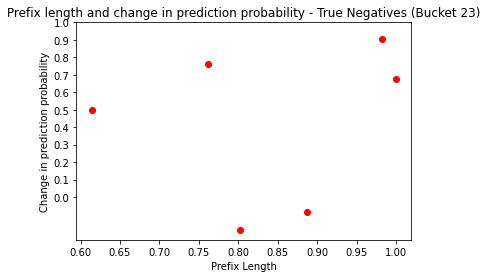

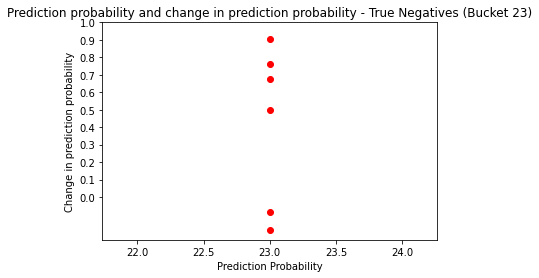

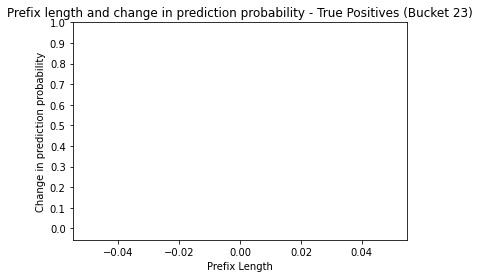

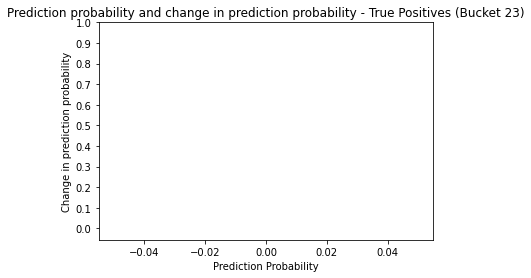

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 50
Creating distribution for feature 2 of 50
Creating distribution for feature 3 of 50
Creating distribution for feature 4 of 50
Creating distribution for feature 5 of 50
Creating distribution for feature 6 of 50
Creating distribution for feature 7 of 50
Creating distribution for feature 8 of 50
Creating distribution for feature 9 of 50
Creating distribution for feature 10 of 50
Creating distribution for feature 11 of 50
Creating distribution for feature 12 of 50
Creating distribution for feature 13 of 50
Creating distribution for feature 14 of 50
Creating distribution for feature 15 of 50
Creating distribution for feature 16 of 50
Creating distribution for feature 17 of 50
Creating distribution for feature 18 of 50
Creating distribution for feature 19 of 50
Creating distribution for feature 20 of 50
Creating distribution for feature 21 of 50
Creating distribution

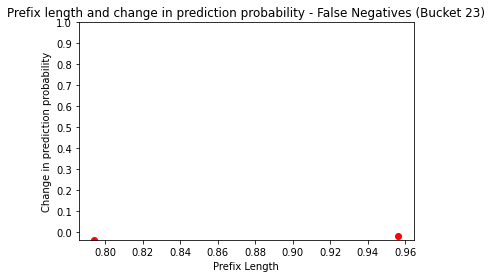

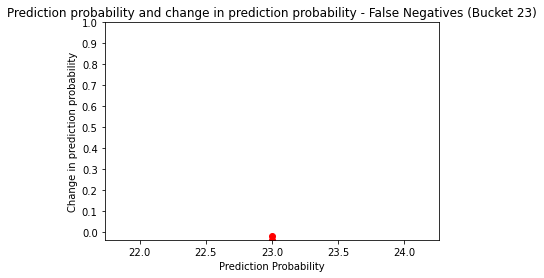

Category 4 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 50
Creating distribution for feature 2 of 50
Creating distribution for feature 3 of 50
Creating distribution for feature 4 of 50
Creating distribution for feature 5 of 50
Creating distribution for feature 6 of 50
Creating distribution for feature 7 of 50
Creating distribution for feature 8 of 50
Creating distribution for feature 9 of 50
Creating distribution for feature 10 of 50
Creating distribution for feature 11 of 50
Creating distribution for feature 12 of 50
Creating distribution for feature 13 of 50
Creating distribution for feature 14 of 50
Creating distribution for feature 15 of 50
Creating distribution for feature 16 of 50
Creating distribution for feature 17 of 50
Creating distribution for feature 18 of 50
Creating distribution for feature 19 of 50
Creating distribution for feature 20 of 50
Creating distribution for feature 21 of 50
Creating distribution

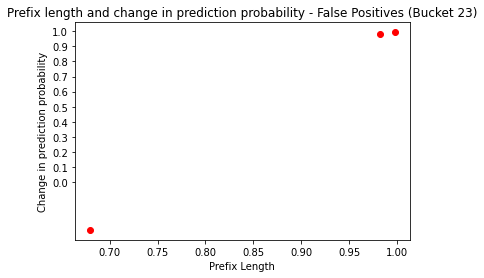

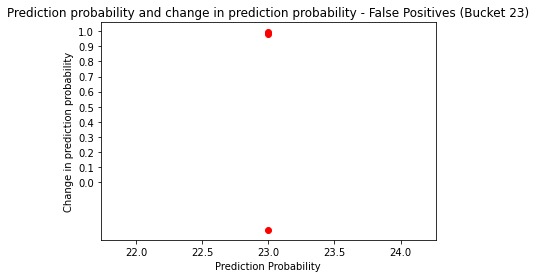

Bucket 24
Generating distributions for bucket
1 of 528 features
2 of 528 features
3 of 528 features
4 of 528 features
5 of 528 features
6 of 528 features
7 of 528 features
8 of 528 features
9 of 528 features
10 of 528 features
11 of 528 features
12 of 528 features
13 of 528 features
14 of 528 features
15 of 528 features
16 of 528 features
17 of 528 features
18 of 528 features
19 of 528 features
20 of 528 features
21 of 528 features
22 of 528 features
23 of 528 features
24 of 528 features
25 of 528 features
26 of 528 features
27 of 528 features
28 of 528 features
29 of 528 features
30 of 528 features
31 of 528 features
32 of 528 features
33 of 528 features
34 of 528 features
35 of 528 features
36 of 528 features
37 of 528 features
38 of 528 features
39 of 528 features
40 of 528 features
41 of 528 features
42 of 528 features
43 of 528 features
44 of 528 features
45 of 528 features
46 of 528 features
47 of 528 features
48 of 528 features
49 of 528 features
50 of 528 features
51 of 528 fea

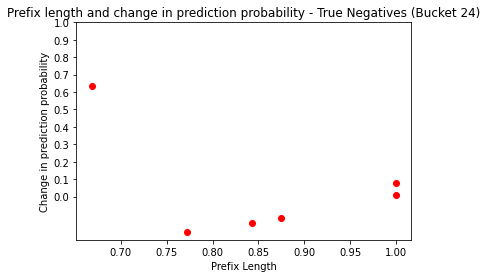

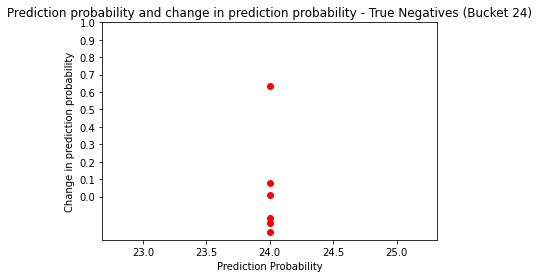

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 53
Creating distribution for feature 2 of 53
Creating distribution for feature 3 of 53
Creating distribution for feature 4 of 53
Creating distribution for feature 5 of 53
Creating distribution for feature 6 of 53
Creating distribution for feature 7 of 53
Creating distribution for feature 8 of 53
Creating distribution for feature 9 of 53
Creating distribution for feature 10 of 53
Creating distribution for feature 11 of 53
Creating distribution for feature 12 of 53
Creating distribution for feature 13 of 53
Creating distribution for feature 14 of 53
Creating distribution for feature 15 of 53
Creating distribution for feature 16 of 53
Creating distribution for feature 17 of 53
Creating distribution for feature 18 of 53
Creating distribution for feature 19 of 53
Creating distribution for feature 20 of 53
Creating distribution for feature 21 of 53
Creating distribution

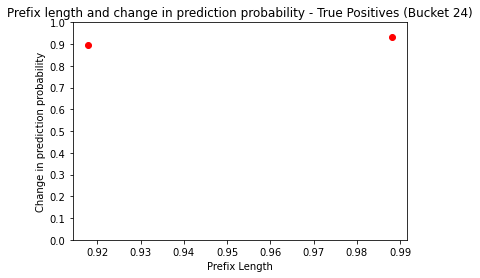

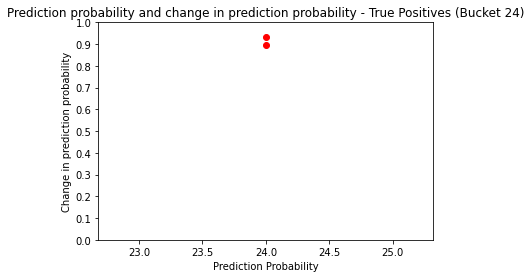

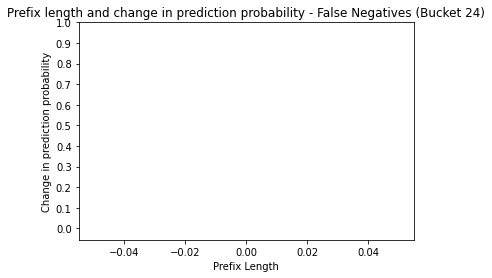

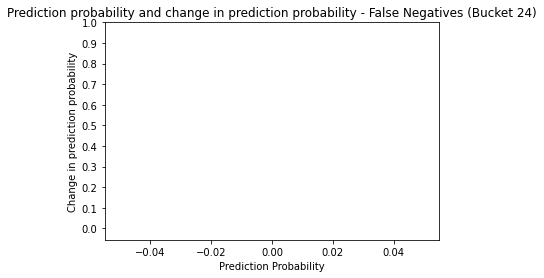

Category 4 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 53
Creating distribution for feature 2 of 53
Creating distribution for feature 3 of 53
Creating distribution for feature 4 of 53
Creating distribution for feature 5 of 53
Creating distribution for feature 6 of 53
Creating distribution for feature 7 of 53
Creating distribution for feature 8 of 53
Creating distribution for feature 9 of 53
Creating distribution for feature 10 of 53
Creating distribution for feature 11 of 53
Creating distribution for feature 12 of 53
Creating distribution for feature 13 of 53
Creating distribution for feature 14 of 53
Creating distribution for feature 15 of 53
Creating distribution for feature 16 of 53
Creating distribution for feature 17 of 53
Creating distribution for feature 18 of 53
Creating distribution for feature 19 of 53
Creating distribution for feature 20 of 53
Creating distribution for feature 21 of 53
Creating distribution

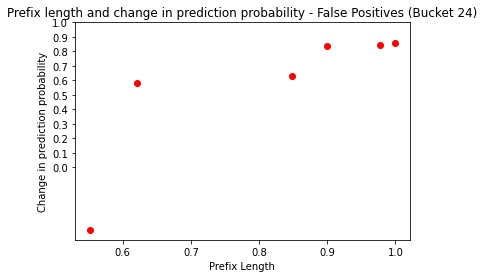

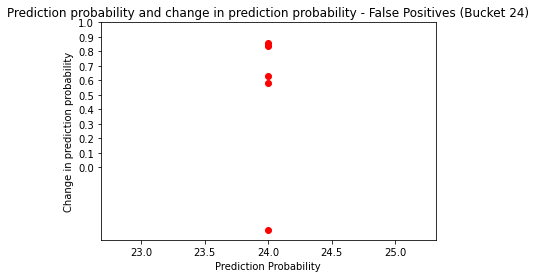

Bucket 25
Generating distributions for bucket
1 of 535 features
2 of 535 features
3 of 535 features
4 of 535 features
5 of 535 features
6 of 535 features
7 of 535 features
8 of 535 features
9 of 535 features
10 of 535 features
11 of 535 features
12 of 535 features
13 of 535 features
14 of 535 features
15 of 535 features
16 of 535 features
17 of 535 features
18 of 535 features
19 of 535 features
20 of 535 features
21 of 535 features
22 of 535 features
23 of 535 features
24 of 535 features
25 of 535 features
26 of 535 features
27 of 535 features
28 of 535 features
29 of 535 features
30 of 535 features
31 of 535 features
32 of 535 features
33 of 535 features
34 of 535 features
35 of 535 features
36 of 535 features
37 of 535 features
38 of 535 features
39 of 535 features
40 of 535 features
41 of 535 features
42 of 535 features
43 of 535 features
44 of 535 features
45 of 535 features
46 of 535 features
47 of 535 features
48 of 535 features
49 of 535 features
50 of 535 features
51 of 535 fea

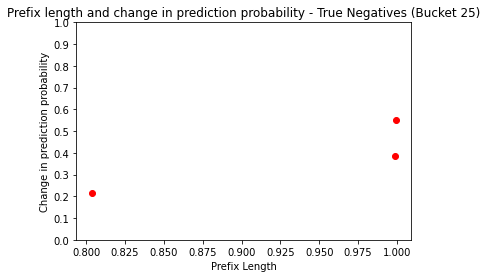

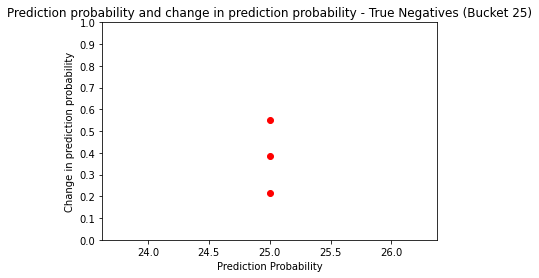

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution

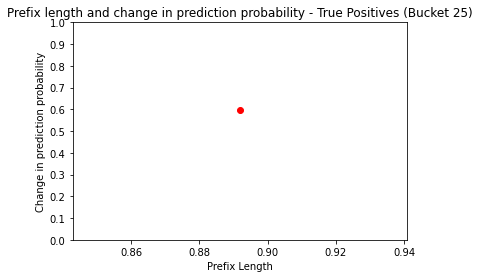

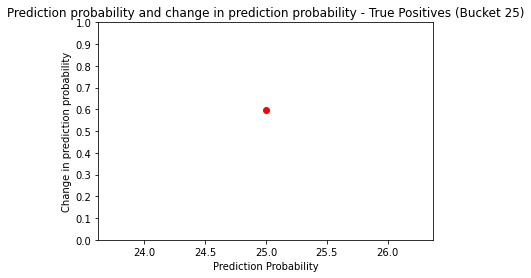

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution

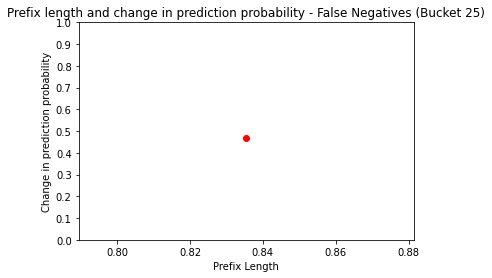

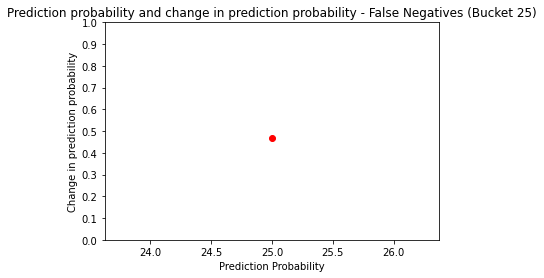

Category 4 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution

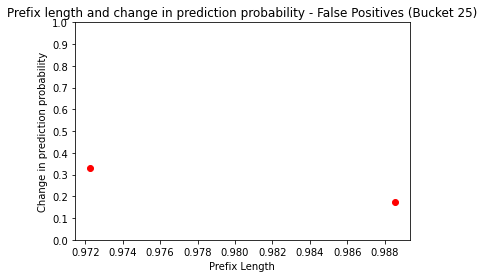

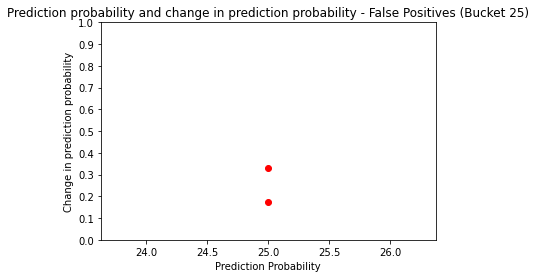

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            
            buckets = range(20, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][0]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

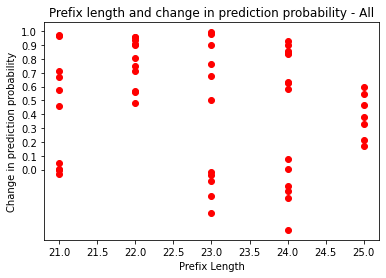

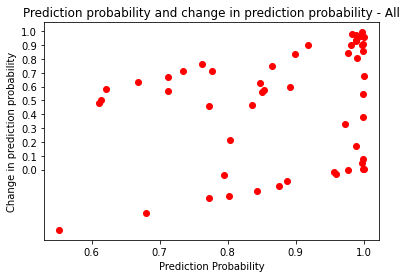

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

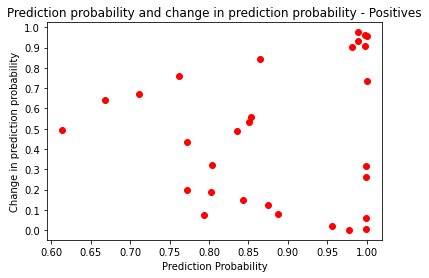

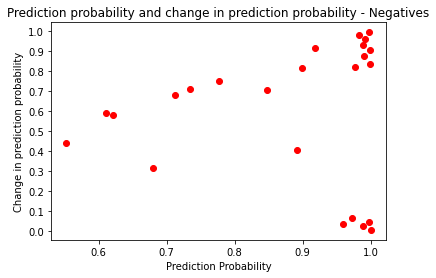

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 21
Category 1 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

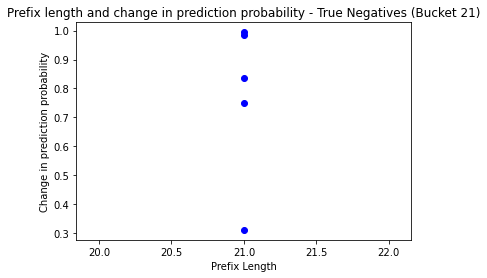

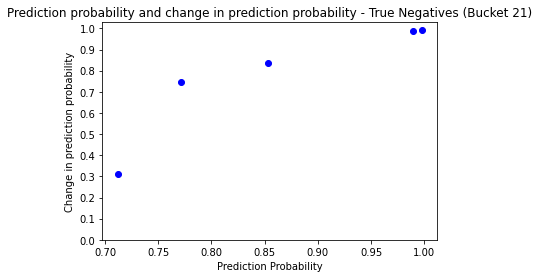

Category 2 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

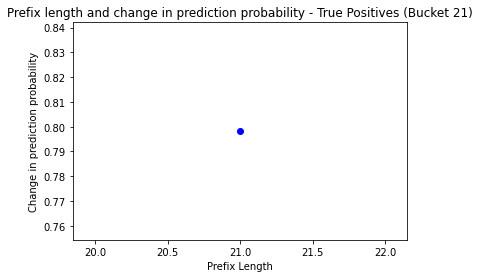

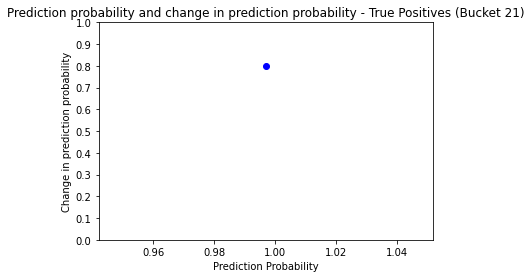

Category 3 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

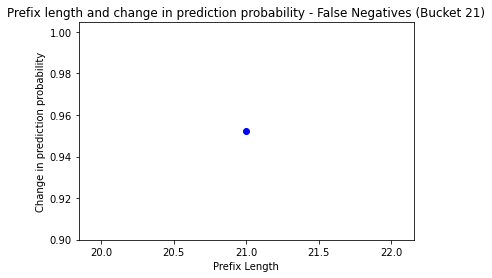

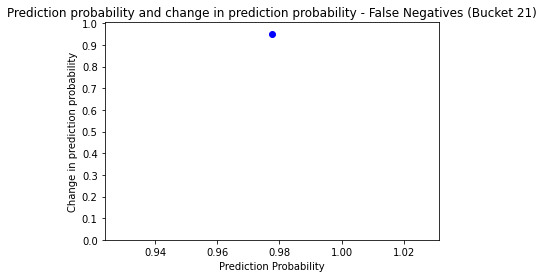

Category 4 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

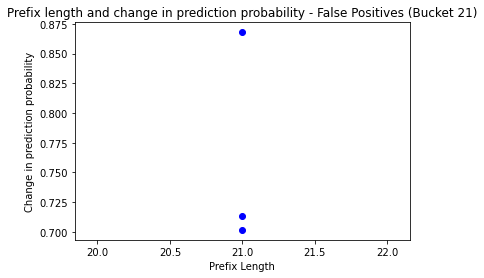

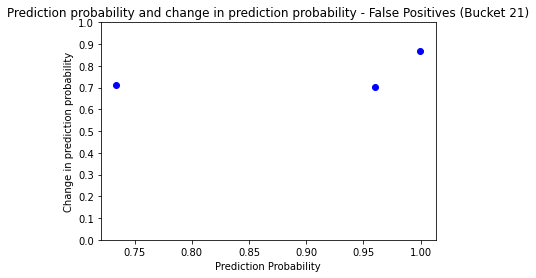

Bucket 22
Category 1 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

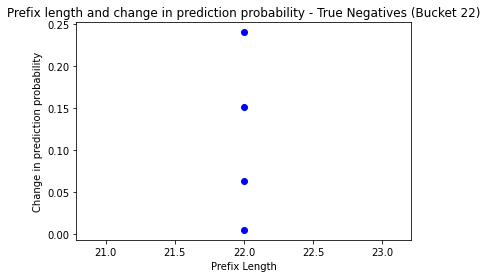

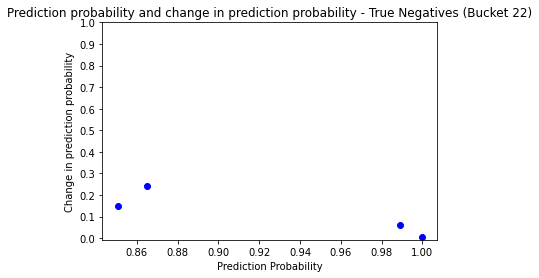

Category 2 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

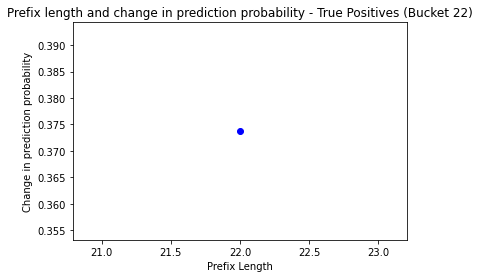

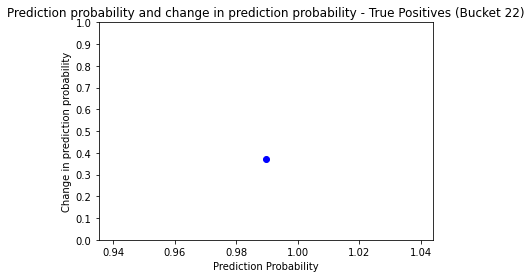

Category 3 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

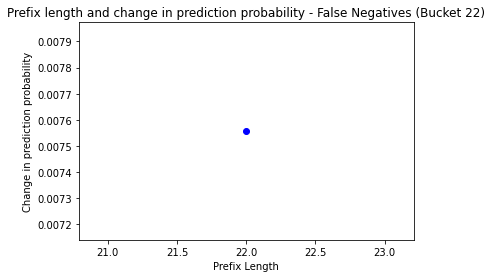

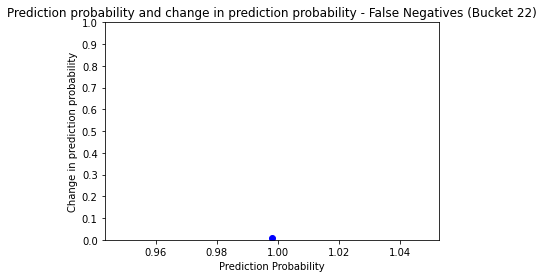

Category 4 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

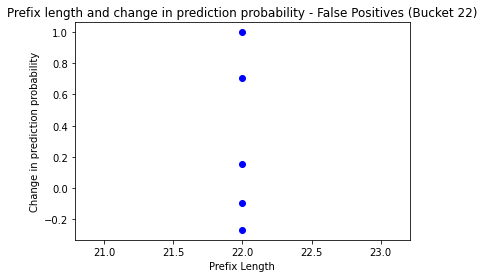

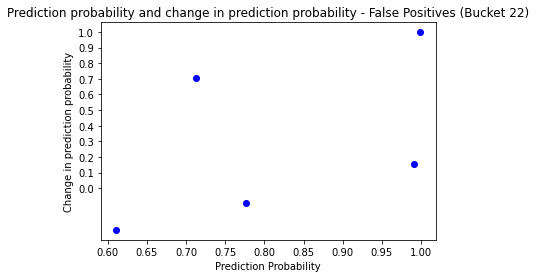

Bucket 23
Category 1 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

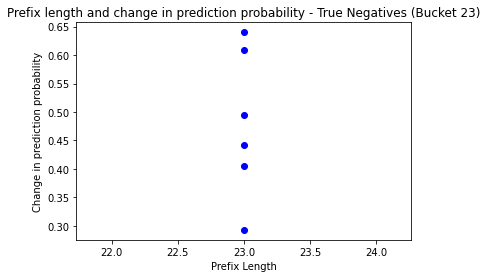

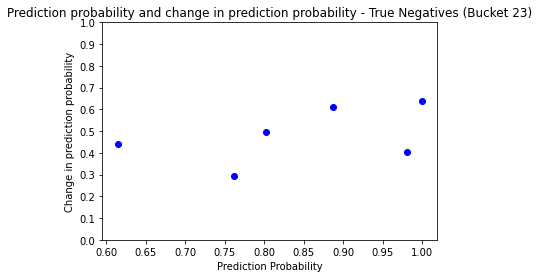

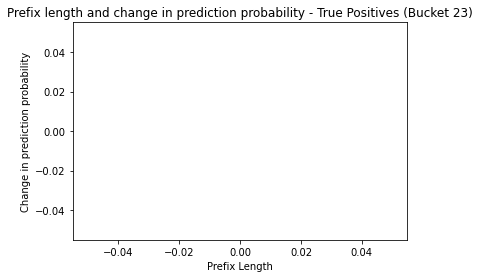

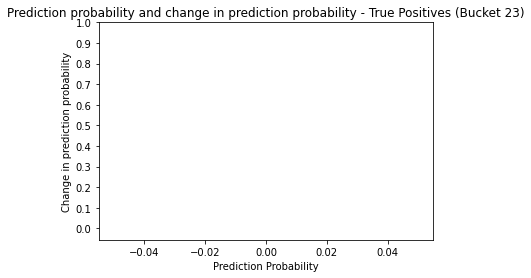

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

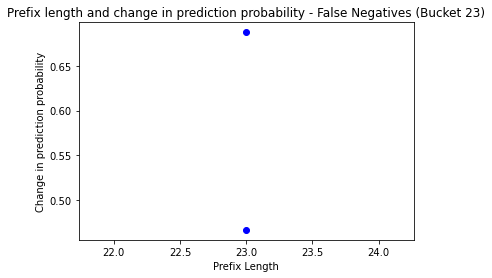

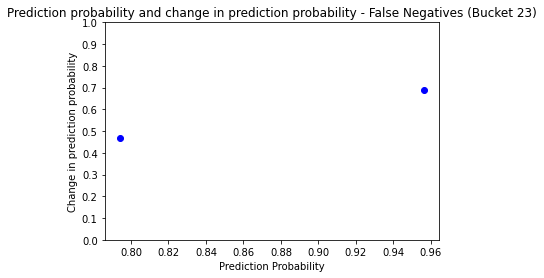

Category 4 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

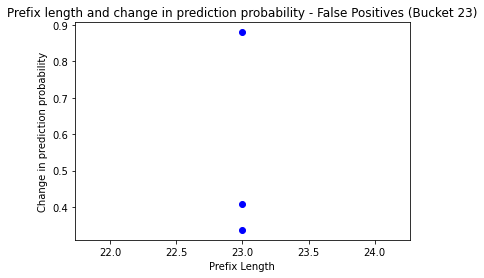

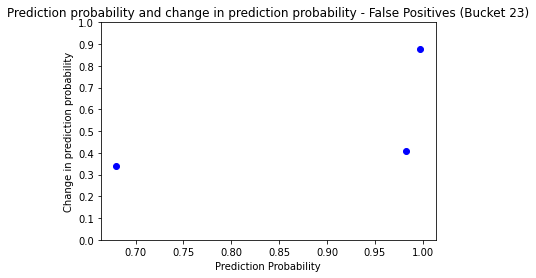

Bucket 24
Category 1 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

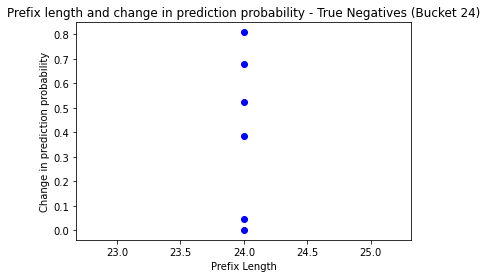

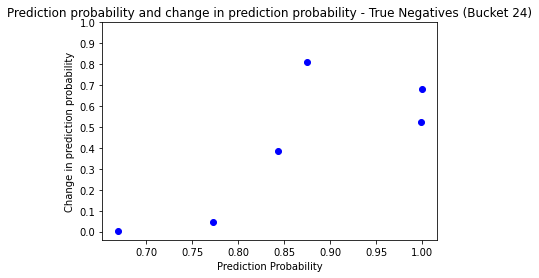

Category 2 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

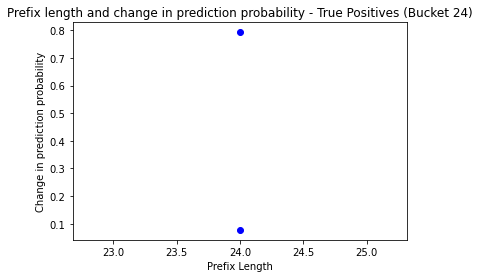

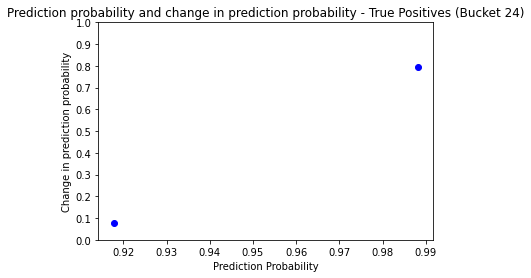

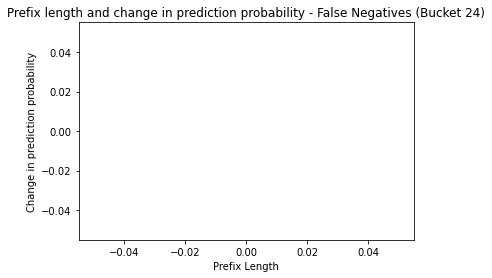

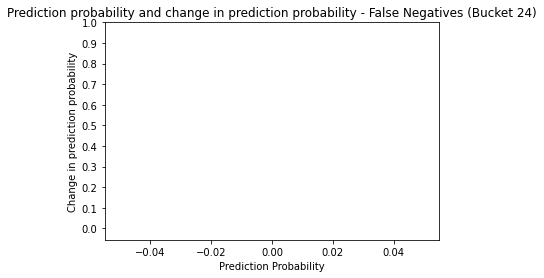

Category 4 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

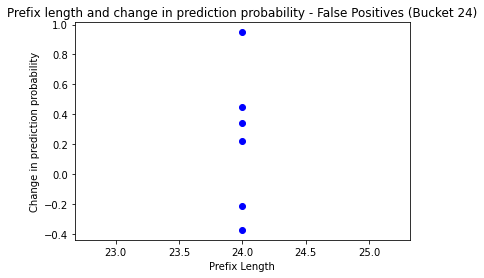

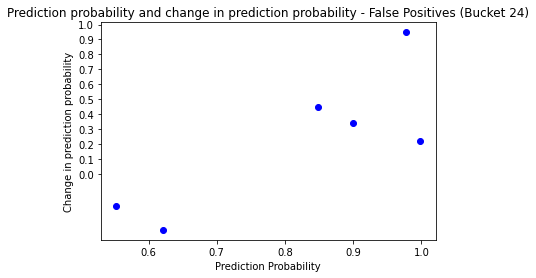

Bucket 25
Category 1 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

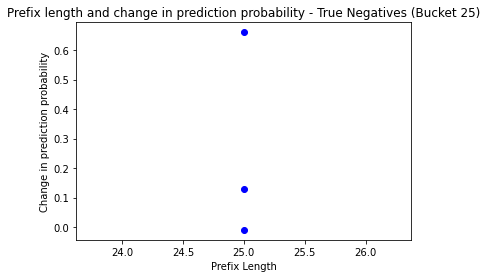

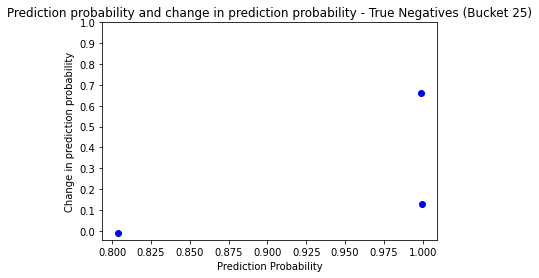

Category 2 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

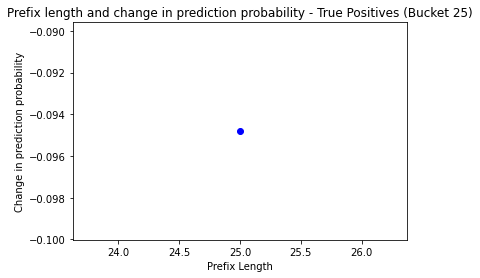

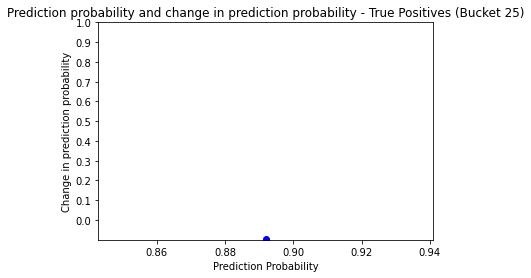

Category 3 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

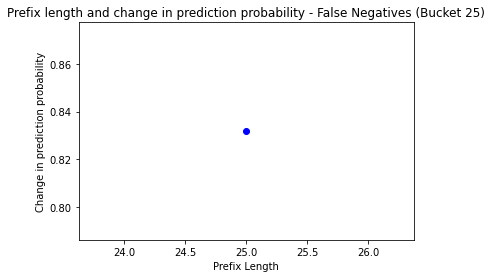

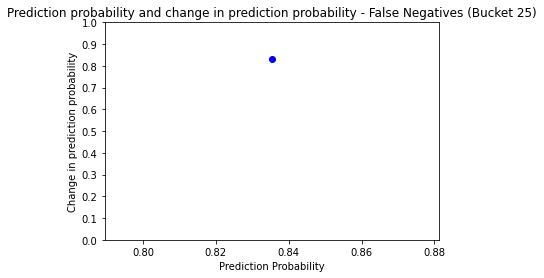

Category 4 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

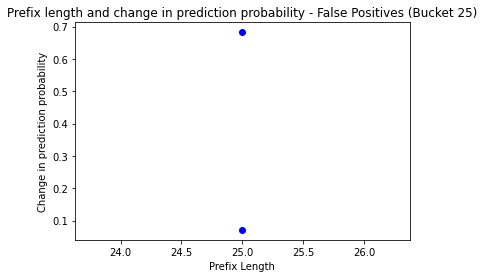

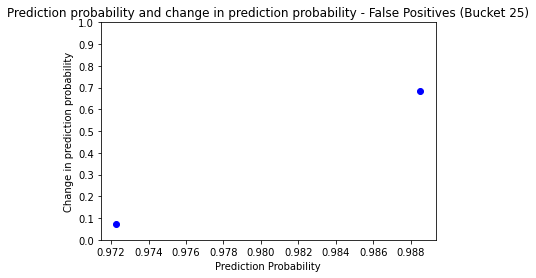

In [13]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(20, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][0]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

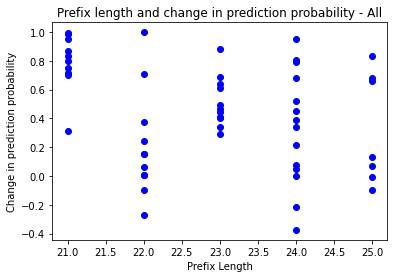

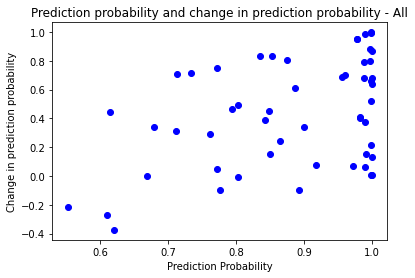

In [14]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

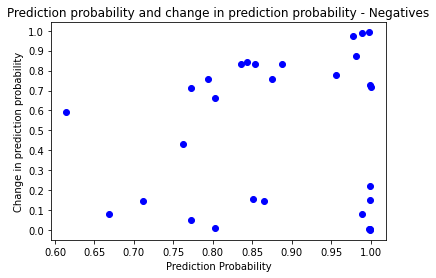

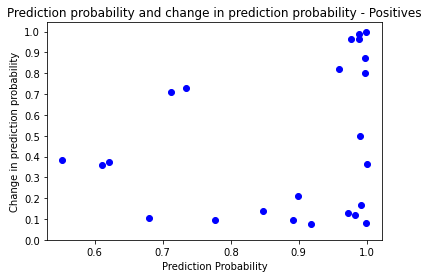

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [16]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

LIME Fidelity Score: 0.4315009413712755 
SHAP Fidelity Score: 0.47511645300388783


In [17]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

Positive predictions: 
LIME Fidelity Score: 0.4952178095892154 
SHAP Fidelity Score: 0.46884960380038104
Negative predictions: 
LIME Fidelity Score: 0.45987274249394733 
SHAP Fidelity Score: 0.5973326886693636
